In [222]:
# load different models
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
string = 'alphamat'
df = pd.read_csv(fr'L:\4portProb_simulations\{string}_qlearning.csv')
q = np.load(fr'L:\4portProb_simulations\{string}_qlearning_values.npy').reshape(df.shape[0], 4)

def data_prep(dataset, hist = 20, trialsinsess = 100, head = False):
    dataset = dataset.groupby(['session']).filter(lambda x: x.reward.size >= trialsinsess)
    dataset['ct0'] = dataset.action.values
    for i in range(1,hist): 
        dataset['ct'+str(i)] = dataset.groupby(['session']).action.shift(i) #previous action
        dataset['shift_t'+str(i-1)] = dataset['ct'+str(i)]==dataset['ct'+str(i-1)]
        dataset['shift_t'+str(i-1)] = dataset['shift_t'+str(i-1)].replace({True: 0, False: 1})
        dataset['rt'+str(i)] = dataset.groupby(['session']).reward.shift(i) # previous reward
        dataset['rt'+str(i)] = dataset['rt'+str(i)]#.replace({0:-1})
#         dataset['choice_t'+str(i)] = dataset['choice_t'+str(i)].replace({1:'a', 2:'b', 3:'c', 4:'d'})
    dataset = dataset.dropna()
    if head == True:
        dataset = dataset.groupby(['session']).head(trialsinsess)

    return dataset
hist = 6
data = data_prep(df, hist = hist, trialsinsess = 100, head = True)


r = data.reward.to_numpy()
r1 = data.rt1.to_numpy()
r2 = data.rt2.to_numpy()
r3 = data.rt3.to_numpy()
r4 = data.rt4.to_numpy()
#  get rpe
a = (data.action.to_numpy(dtype=int))-1
rpe = r - q[data.index, a]

# make lin reg model
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

# X = np.column_stack((r))
X = r1.reshape(-1, 1)
y = rpe
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
reg = LinearRegression(fit_intercept = True).fit(X_train, y_train)
reg.score(X_test, y_test)


# plt.plot(np.arange(len(reg.coef_))-4, reg.coef_, 'o-')
# # show values of each point on the plot above the point
# for i, txt in enumerate(reg.coef_):
#     plt.annotate(np.round(txt, 4), (i-4, reg.coef_[i]))
# plt.axhline(0, color='black', lw=0.5)
# plt.xticks(np.arange(len(reg.coef_))-4)
# plt.title(string+' sim')

0.0007156947927604573

In [223]:
d1 = np.abs(data.action - data.ct1)
d2 = np.abs(data.action - data.ct2)
d3 = np.abs(data.action - data.ct3)
coefs = np.zeros((4, 3))
intercepts = np.zeros((4, 3))
for trial_lag in range(3):
    r_arr = [r1, r2, r3]
    d_arr = [d1, d2, d3]
    for dist in range(4):
        y = rpe[d_arr[trial_lag]==dist]
        X = r_arr[trial_lag][d_arr[trial_lag]==dist].reshape(-1, 1)
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

        reg = LinearRegression(fit_intercept = True).fit(X_train, y_train)
        coefs[dist, trial_lag] = reg.coef_[0]
        print(reg.coef_, dist, trial_lag)
        intercepts[dist, trial_lag] = reg.intercept_

[-0.00868488] 0 0
[-0.00338337] 1 0
[0.00717306] 2 0
[-0.02361826] 3 0
[-0.00311152] 0 1
[0.01482391] 1 1
[0.02502795] 2 1
[-0.02376937] 3 1
[-0.00259133] 0 2
[-0.00782166] 1 2
[0.02041648] 2 2
[-0.05353609] 3 2


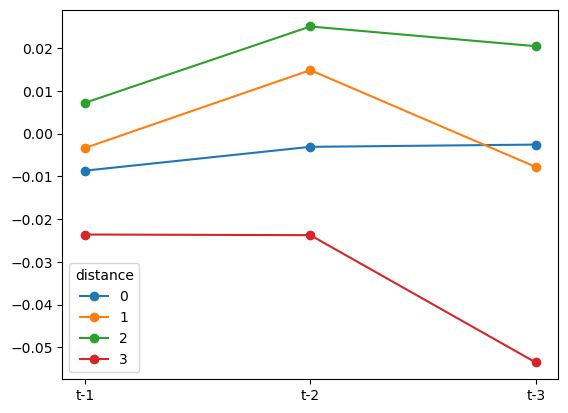

In [224]:
plt.plot(coefs.T, 'o-')
plt.xticks([0, 1, 2], ['t-1', 't-2', 't-3'])
plt.legend([0, 1, 2, 3], title = 'distance')